In [25]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import sklearn
import skimage
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [4]:
DATASET_PATH = 'dataset/'
target_size = (256, 256)

LBP_RADIUS = 3
LBP_POINTS = 8 * LBP_RADIUS

# Preprocess and Feature Extraction
---

In [5]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)

    img = cv2.resize(img, target_size)

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_gray_smooth = cv2.GaussianBlur(img_gray, (5, 5), 0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_gray_enhanced = clahe.apply(img_gray_smooth)

    return img_hsv, img_gray_enhanced

In [6]:
def extract_hsv_features(hsv):
    bins = 8
    hist_h = cv2.calcHist([hsv], [0], None, [bins], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [bins], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [bins], [0, 256])

    cv2.normalize(hist_h, hist_h)
    cv2.normalize(hist_s, hist_s)
    cv2.normalize(hist_v, hist_v)

    return np.concatenate([hist_h.flatten(), hist_s.flatten(), hist_v.flatten()])

In [7]:
def extract_glcm_features(img_gray):
    glcm = graycomatrix(img_gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    feats = []
    for prop in properties:
        val = graycoprops(glcm, prop).mean()
        feats.append(val)
    return np.array(feats)

In [8]:
def extract_lbp_features(img_gray):
    lbp = local_binary_pattern(img_gray, LBP_POINTS, LBP_RADIUS, method='uniform')

    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist

In [9]:
def build_features(dataset_path):
    X = []
    y = []

    classes = os.listdir(dataset_path)
    print(f'Classes found: {classes}')

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)

        print(f'Currently processing: {class_path}')

        for img_name in tqdm(images):
            img_path = os.path.join(class_path, img_name)

            img_hsv, img_gray = preprocess_image(img_path)
            if(img_hsv is None):
                continue

            # extract features
            f_color = extract_hsv_features(img_hsv)
            f_glcm = extract_glcm_features(img_gray)
            f_lbp = extract_lbp_features(img_gray)

            combined_features = np.hstack([f_color, f_glcm, f_lbp])

            X.append(combined_features)
            y.append(class_name)

    return np.array(X), np.array(y)

In [10]:
X, y = build_features(DATASET_PATH)

print(X.shape, y.shape)

Classes found: ['H5', 'H1', 'H2', 'H3', 'H6']
Currently processing: dataset/H5


100%|██████████| 818/818 [01:11<00:00, 11.50it/s]


Currently processing: dataset/H1


100%|██████████| 4404/4404 [06:16<00:00, 11.70it/s]


Currently processing: dataset/H2


100%|██████████| 2334/2334 [03:19<00:00, 11.71it/s]


Currently processing: dataset/H3


100%|██████████| 819/819 [01:10<00:00, 11.64it/s]


Currently processing: dataset/H6


100%|██████████| 739/739 [01:03<00:00, 11.64it/s]

(9114, 55) (9114,)


In [11]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [12]:
print(f"Original training shape: {X_train.shape}")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled training shape: {X_train_resampled.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

Original training shape: (7291, 55)
Resampled training shape: (17730, 55)


# Train model
---

### Random Forest

In [13]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)


RandomForestClassifier()

In [14]:
y_pred_rfc = rf_model.predict(X_test)

print(f"Akurasi Random Forest: {accuracy_score(y_test, y_pred_rfc) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rfc, target_names=le.classes_))

Akurasi Random Forest: 85.24%

Classification Report:
              precision    recall  f1-score   support

          H1       0.82      0.96      0.88       858
          H2       0.87      0.68      0.76       492
          H3       0.91      0.68      0.78       157
          H5       0.91      0.90      0.91       175
          H6       0.96      0.94      0.95       141

    accuracy                           0.85      1823
   macro avg       0.89      0.83      0.86      1823
weighted avg       0.86      0.85      0.85      1823



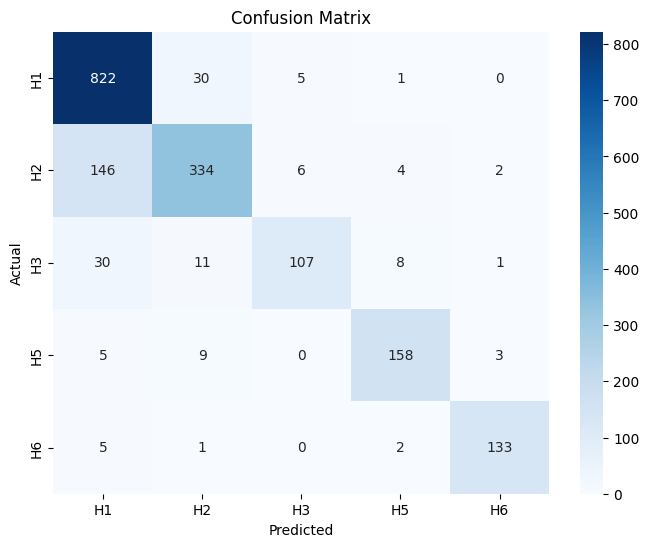

In [15]:
cm = confusion_matrix(y_test, y_pred_rfc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### SVM

In [16]:
svm_model = SVC()
svm_model.fit(scaler.transform(X_train), y_train) # Must use scaled data

SVC()

In [17]:
y_pred_svm = svm_model.predict(scaler.transform(X_test))

print(f"Akurasi SVM: {accuracy_score(y_test, y_pred_svm) * 100:.2f}%")
print("Classification Report SVM:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

Akurasi SVM: 76.52%
Classification Report SVM:
              precision    recall  f1-score   support

          H1       0.72      0.96      0.82       858
          H2       0.77      0.43      0.55       492
          H3       0.88      0.57      0.69       157
          H5       0.86      0.83      0.84       175
          H6       0.94      0.91      0.93       141

    accuracy                           0.77      1823
   macro avg       0.83      0.74      0.77      1823
weighted avg       0.78      0.77      0.75      1823



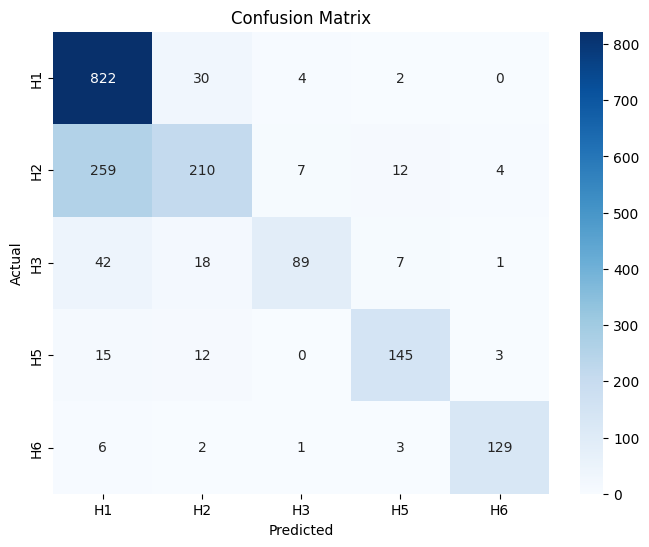

In [18]:
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### KNN

In [19]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train_resampled)

KNeighborsClassifier()

In [20]:
y_pred_knn = knn_model.predict(X_test_scaled)

print(f"Akurasi KNN: {accuracy_score(y_test, y_pred_knn) * 100:.2f}%")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

Akurasi KNN: 82.72%
              precision    recall  f1-score   support

          H1       0.91      0.79      0.85       858
          H2       0.77      0.77      0.77       492
          H3       0.62      0.90      0.74       157
          H5       0.88      0.97      0.92       175
          H6       0.87      0.96      0.91       141

    accuracy                           0.83      1823
   macro avg       0.81      0.88      0.84      1823
weighted avg       0.84      0.83      0.83      1823



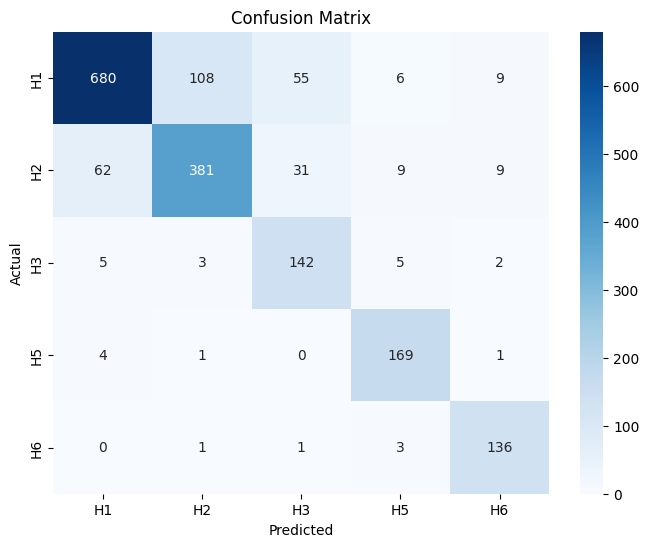

In [21]:
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### XGBoost

In [22]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [23]:
y_pred_xgb = xgb_model.predict(X_test)

print(f"Akurasi XGBoost: {accuracy_score(y_test, y_pred_xgb) * 100:.2f}%")
print("Classification Report XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

Akurasi XGBoost: 87.71%
Classification Report XGBoost:
              precision    recall  f1-score   support

          H1       0.85      0.96      0.90       858
          H2       0.87      0.74      0.80       492
          H3       0.91      0.73      0.81       157
          H5       0.96      0.93      0.94       175
          H6       0.96      0.97      0.96       141

    accuracy                           0.88      1823
   macro avg       0.91      0.87      0.88      1823
weighted avg       0.88      0.88      0.87      1823



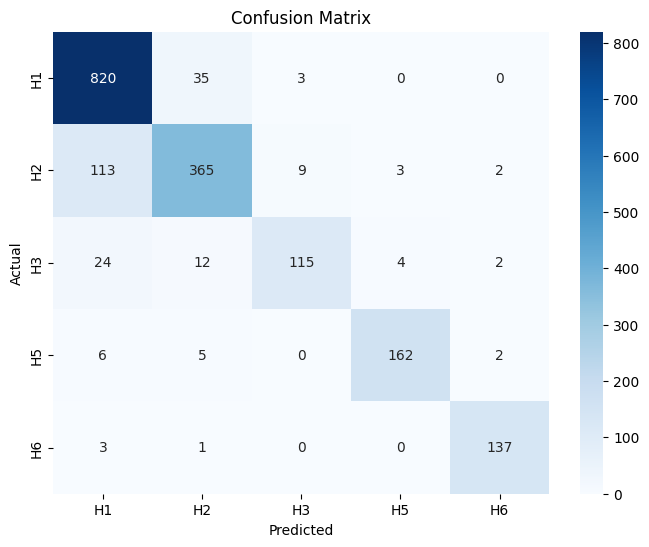

In [24]:
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Hyperparameter Tuning
---

### Random Forest

In [53]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'class_weight' : ['balanced', 'balanced_subsample']
}

In [54]:
rf_base = RandomForestClassifier(random_state=42)

In [55]:
rf_grid = GridSearchCV(rf_base, rf_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'max_depth': [None, 10], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [57]:
print(f"Best Random Forest Params: {rf_grid.best_params_}")
print(f"Best Random Forest Accuracy (Train): {rf_grid.best_score_:.4f}")

Best Random Forest Params: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Accuracy (Train): 0.8409


### XGBoost

In [30]:
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 1.0]
}

In [32]:
xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

In [34]:
xgb_grid = GridSearchCV(xgb_base, xgb_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:08:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constrain...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 10], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [35]:
print(f"Best XGBoost Params: {xgb_grid.best_params_}")
print(f"Best XGBoost Accuracy (Train): {xgb_grid.best_score_:.4f}")

Best XGBoost Params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost Accuracy (Train): 0.8638


In [60]:
best_rf_model = rf_grid.best_estimator_
best_xgb_model = xgb_grid.best_estimator_

# Export Model
---

In [ ]:
import joblib

joblib.dump(best_rf_model, 'rf_defungi.joblib')
joblib.dump(best_xgb_model, 'xgb_defungi.joblib')
joblib.dump(scaler, 'scaler_defungi.joblib')

print("Models saved.")

Models saved.
